# Get Data

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN, ConvLSTM2D
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, History

start = datetime.datetime(2012, 6, 1)
end = datetime.datetime(2020, 6, 1)

df = web.DataReader("GOOGL","yahoo" ,start, end)
print(f"dataset shape is {df.shape}")
df

dataset shape is (2012, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-06-01,286.611603,284.459473,286.181183,285.775787,6109600.0,285.775787
2012-06-04,290.535522,285.290283,285.395386,289.584595,4860500.0,289.584595
2012-06-05,289.354340,283.518524,288.013000,285.490479,4675100.0,285.490479
2012-06-06,291.276276,287.092102,288.528534,290.575562,4187400.0,290.575562
2012-06-07,294.239227,288.913910,294.094086,289.404419,3513400.0,289.404419
...,...,...,...,...,...,...
2020-05-26,1445.109985,1419.400024,1441.959961,1421.369995,2229500.0,1421.369995
2020-05-27,1425.349976,1394.599976,1420.000000,1420.280029,1584200.0,1420.280029
2020-05-28,1444.459961,1399.079956,1400.000000,1418.239990,1758500.0,1418.239990


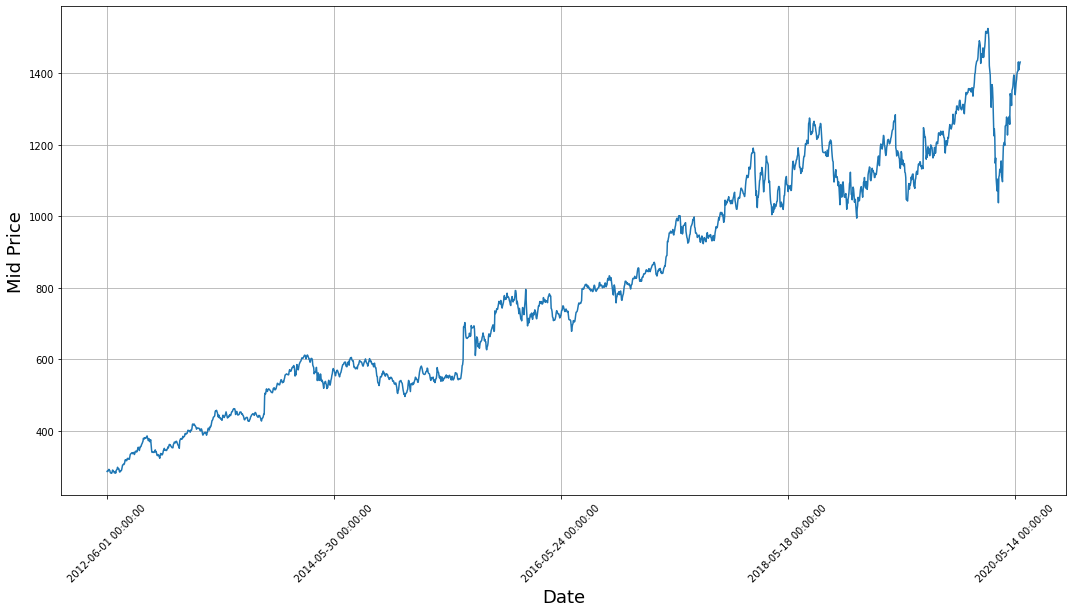

In [2]:
date_ = pd.DataFrame(df.index)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),date_['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.grid()
plt.show()

# Preprocessing

In [3]:
# split training set and test set

PRICE_TO_PREDICT = 'Close'
FEATURES = [PRICE_TO_PREDICT]
SPLIT = int(df.shape[0] * .8)

training_set = df[FEATURES][:SPLIT].values
test_set = df[FEATURES][SPLIT:].values
print(f"training set shape: {training_set.shape} \ntest set shape: {test_set.shape}")

training set shape: (1609, 1) 
test set shape: (403, 1)


In [4]:
# scaling features

scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [5]:
# preprocess data to feed our model

TIME_STEP = 16
x_train = []
y_train = []

for i in range(TIME_STEP, SPLIT):
    x_train.append(training_set_scaled[i-TIME_STEP:i, :])
    y_train.append(training_set_scaled[i,:])

x_train, y_train = np.array(x_train), np.array(y_train)
print(f"x train shape: {x_train.shape} \ny train shape: {y_train.shape}")

x train shape: (1593, 16, 1) 
y train shape: (1593, 1)


In [6]:
# preprocess test data

dataset_train = df.iloc[:SPLIT, 3:4]
dataset_test = df.iloc[SPLIT:, 3:4]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = df[FEATURES][SPLIT - TIME_STEP:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(TIME_STEP, len(inputs)):
    x_test.append(inputs[i-TIME_STEP:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"x test shape: {x_test.shape}")

x test shape: (403, 16, 1)


# PART I,II

## LSTM Model

In [7]:
history_LSTM = History()

model = Sequential()

model.add(LSTM(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(LSTM(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

start = time()
model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[history_LSTM])
end = time()
LSTM_time = end - start
print(f"model trained in {round(LSTM_time, 2)} second")
print(model.summary())

model trained in 17.48 second
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 16, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)             

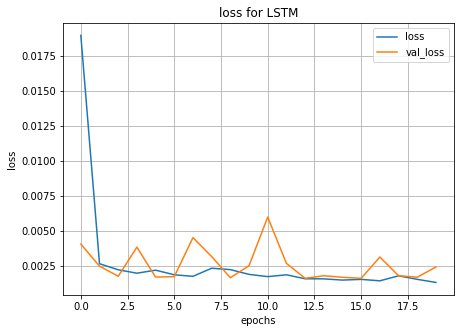

In [8]:
ls = pd.DataFrame({'loss':history_LSTM.history['loss'],
                   'val_loss':history_LSTM.history['val_loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss'), plt.title('loss for LSTM')
plt.grid()

In [9]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price_LSTM = scaler.inverse_transform(predicted_stock_price)

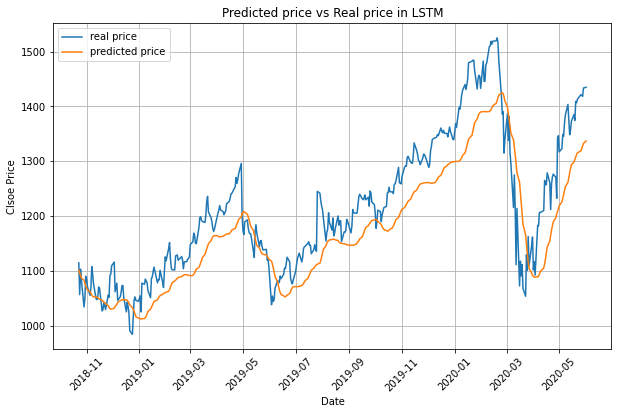

In [10]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_LSTM,  label = 'predicted price')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.title('Predicted price vs Real price in LSTM')
plt.legend()
plt.grid()
plt.show()

## GRU Model

In [11]:
# GRU

history_GRU = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

start = time()
model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[history_GRU])
end = time()
GRU_time = end - start
print(f"model trained in {round(GRU_time, 2)} second")
print(model.summary())

model trained in 10.16 second
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16, 50)            7950      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16, 50)            15300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)         

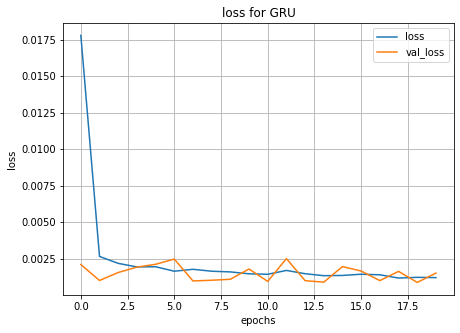

In [12]:
ls = pd.DataFrame({'loss':history_GRU.history['loss'],
                   'val_loss':history_GRU.history['val_loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss'), plt.title('loss for GRU')
plt.grid()

In [13]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU = scaler.inverse_transform(predicted_stock_price)

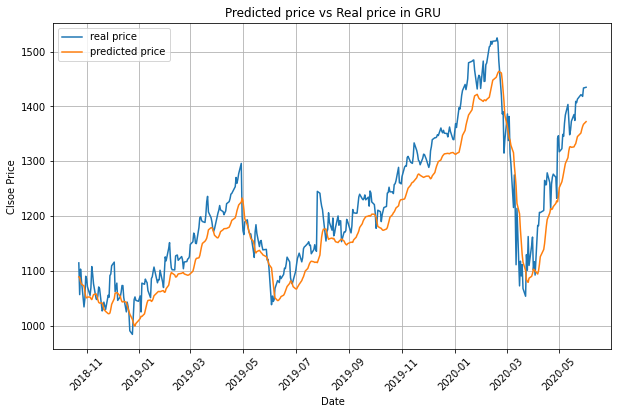

In [14]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU,  label = 'predicted price')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.title('Predicted price vs Real price in GRU')
plt.legend()
plt.grid()
plt.show()

## RNN Model

In [15]:
# GRU

history_RNN = History()

model = Sequential()

model.add(SimpleRNN(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

start = time()
model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[history_RNN])
end = time()
RNN_time = end - start
print(f"model trained in {round(RNN_time, 2)} second")
print(model.summary())

model trained in 30.77 second
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 16, 50)            2600      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16, 50)            5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)         

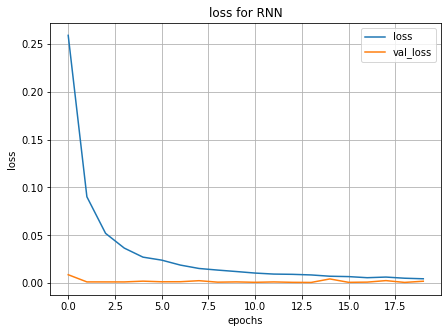

In [16]:
ls = pd.DataFrame({'loss':history_RNN.history['loss'],
                   'val_loss':history_RNN.history['val_loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss'), plt.title('loss for RNN')
plt.grid()

In [17]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price_RNN = scaler.inverse_transform(predicted_stock_price)

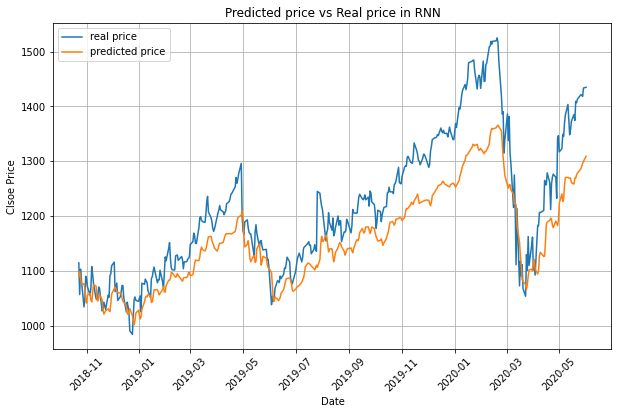

In [18]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_RNN,  label = 'predicted price')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.title('Predicted price vs Real price in RNN')
plt.legend()
plt.grid()
plt.show()

## RNN vs GRU vs LSTM

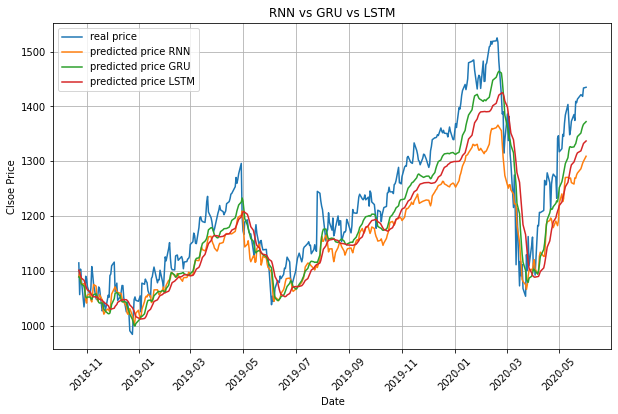

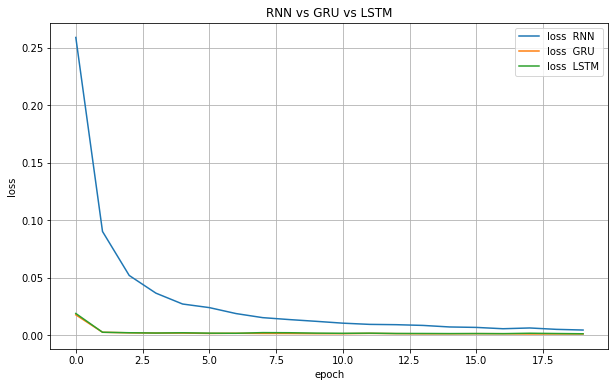

accuracy RNN: 0.6553192217911817 
accuracy GRU: 0.8482451098252253 
accuracy LSTM: 0.7162940443493779
RNN time consumption: 30.769502878189087 
GRU time consumption: 10.162668704986572 
LSTM time consumption: 17.47999906539917


In [19]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_RNN,  label = 'predicted price RNN')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU,  label = 'predicted price GRU')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_LSTM,  label = 'predicted price LSTM')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.title('RNN vs GRU vs LSTM')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (10,6))
plt.plot(history_RNN.history['loss'], label = 'loss  RNN')
plt.plot(history_GRU.history['loss'], label = 'loss  GRU')
plt.plot(history_LSTM.history['loss'], label = 'loss  LSTM')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('RNN vs GRU vs LSTM')
plt.legend()
plt.grid()
plt.show()
print(f"accuracy RNN: {r2_score(dataset_test.values, predicted_stock_price_RNN)}",
      f"\naccuracy GRU: {r2_score(dataset_test.values, predicted_stock_price_GRU)}",
      f"\naccuracy LSTM: {r2_score(dataset_test.values, predicted_stock_price_LSTM)}")
GRU_time

print(f"RNN time consumption: {RNN_time}",
      f"\nGRU time consumption: {GRU_time}",
      f"\nLSTM time consumption: {LSTM_time}")

# PART III

## MAE vs MSE

In [20]:
# GRU MAE

mae_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mae')

start = time()
model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[mae_history])
end = time()
GRU_time = end - start
print(f"model trained in {round(GRU_time, 2)} second")

model trained in 10.24 second


In [21]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_MAE = scaler.inverse_transform(predicted_stock_price)

In [22]:
# GRU MSE

mse_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mse')

start = time()
model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[mse_history])
end = time()
GRU_time = end - start
print(f"model trained in {round(GRU_time, 2)} second")

model trained in 10.22 second


In [23]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_MSE = scaler.inverse_transform(predicted_stock_price)

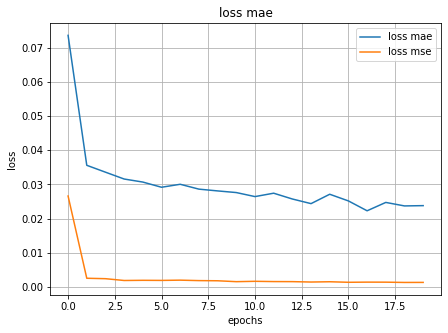

In [24]:
ls = pd.DataFrame({'loss mae':mae_history.history['loss'],
                   'loss mse':mse_history.history['loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss'), plt.title('loss mae')
plt.grid()

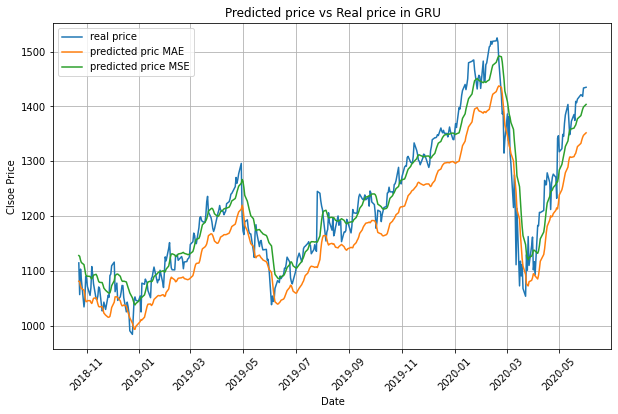

In [25]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_MAE,  label = 'predicted pric MAE')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_MSE,  label = 'predicted price MSE')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.title('Predicted price vs Real price in GRU')
plt.legend()
plt.grid()
plt.show()

## ADAM vs ADAgrad vs RMSprop

In [26]:
# GRU adam

adam_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[adam_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_adam = scaler.inverse_transform(predicted_stock_price)

In [27]:
# GRU adagrad

adagrad_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adagrad',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[adagrad_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_adagrad = scaler.inverse_transform(predicted_stock_price)

In [28]:
# GRU rmsprop

rmsprop_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'rmsprop',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[rmsprop_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_rmsprop = scaler.inverse_transform(predicted_stock_price)

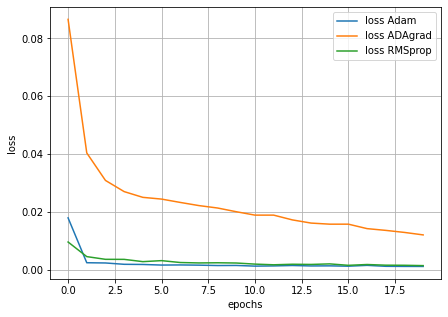

In [29]:
ls = pd.DataFrame({'loss Adam':adam_history.history['loss'],
                   'loss ADAgrad':adagrad_history.history['loss'],
                   'loss RMSprop':rmsprop_history.history['loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss')
plt.grid()

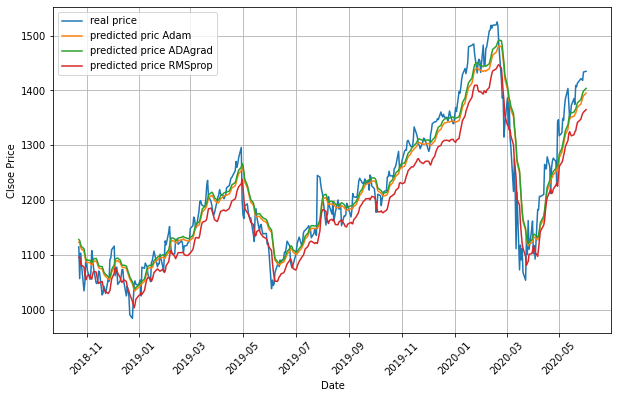

In [30]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_adam,  label = 'predicted pric Adam')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_MSE,  label = 'predicted price ADAgrad')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_rmsprop,  label = 'predicted price RMSprop')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.legend()
plt.grid()
plt.show()

# PART IV

## Dropout Effect

In [31]:
# GRU dropout

dropout_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[dropout_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_dropout = scaler.inverse_transform(predicted_stock_price)

In [32]:
# GRU no dropout

nodropout_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))

model.add(GRU(units = 50,
               return_sequences = True))

model.add(GRU(units = 50))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[nodropout_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_nodropout = scaler.inverse_transform(predicted_stock_price)

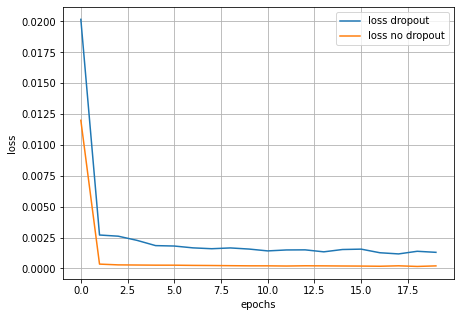

In [33]:
ls = pd.DataFrame({'loss dropout':dropout_history.history['loss'],
                   'loss no dropout':nodropout_history.history['loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss')
plt.grid()

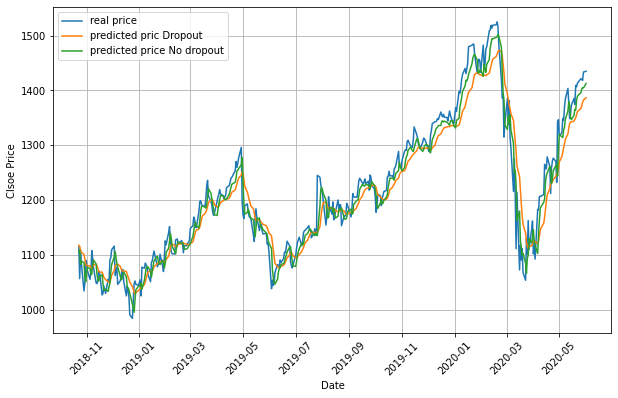

In [34]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_dropout,  label = 'predicted pric Dropout')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_nodropout,  label = 'predicted price No dropout')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.legend()
plt.grid()
plt.show()

# PART V

## ARIMA Predition

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1  predicted=1371.065993, expected=1384.339966
2  predicted=1378.449557, expected=1403.589966
3  predicted=1405.152895, expected=1375.180054
4  predicted=1374.320686, expected=1348.329956
5  predicted=1357.116736, expected=1356.859985
6  predicted=1354.159291, expected=1373.060059
7  predicted=1374.480236, expected=1385.180054
8  predicted=1381.148690, expected=1374.400024
9  predicted=1377.974652, expected=1409.160034
10  predicted=1404.963332, expected=1406.750000
11  predicted=1406.627757, expected=1413.239990
12  predicted=1413.453892, expected=1421.369995
13  predicted=1420.471185, expected=1420.280029
14  predicted=1420.958682, expected=1418.239990
15  predicted=1419.005459, expected=1433.520020
16  predicted=1432.869961, expected=1434.869995
This took 8.56 seconds.
Test MSE: 262.7294


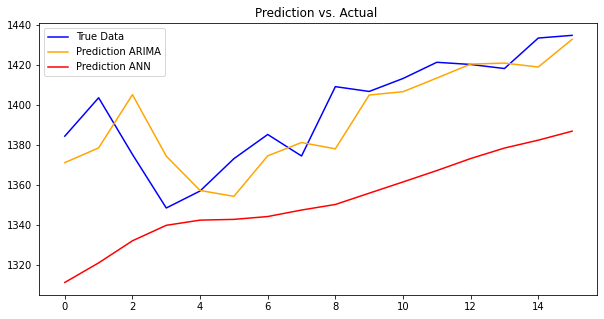

ARIMA accuracy: 0.6086831902448799 ANN accuracy: -2.556950329651032


In [35]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import time

Input = df['Close']
X = Input
start = time.time()

size = len(X)-16 
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(1,1,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('%d  predicted=%f, expected=%f' % (t+1, yhat, obs))
 
end = time.time()
print('This took %.2f seconds.' %(end - start))

error = mean_squared_error(test, predictions)
print('Test MSE: %.4f' % error)

# plot
from matplotlib import pyplot as plt
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('Prediction vs. Actual ')
    ax.plot(true_data, label='True Data', color='blue')
    ax.plot(predicted_data, label='Prediction ARIMA', color='orange')
    ax.plot(predicted_stock_price_GRU_dropout[-16:], label='Prediction ANN', color='red')

    plt.legend()
    plt.show()

plot_predicted(predictions, test.values)
print(f"ARIMA accuracy: {r2_score(test.values, predictions)}",
      f"ANN accuracy: {r2_score(test.values, predicted_stock_price_GRU_dropout[-16:])}")

# PART VII

## Adding more Dense layer

In [36]:
# GRU dropout more Dense

dropout_moredense_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 16))
model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[dropout_moredense_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_dropout_moredense = scaler.inverse_transform(predicted_stock_price)

In [37]:
# GRU no dropout more Dense

nodropout_moredense_history = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))

model.add(GRU(units = 50,
               return_sequences = True))

model.add(GRU(units = 50))

model.add(Dense(units = 16))
model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mse')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[nodropout_moredense_history])

predicted_stock_price = model.predict(x_test)
predicted_stock_price_GRU_nodropout_moredense = scaler.inverse_transform(predicted_stock_price)

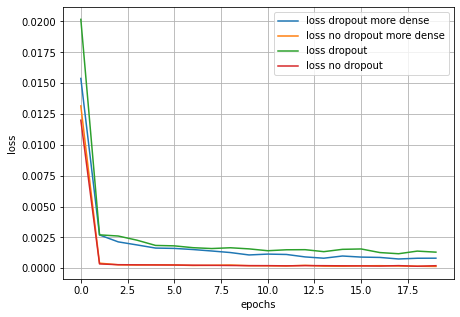

In [38]:
ls = pd.DataFrame({'loss dropout more dense':dropout_moredense_history.history['loss'],
                   'loss no dropout more dense':nodropout_moredense_history.history['loss'],
                   'loss dropout':dropout_history.history['loss'],
                   'loss no dropout':nodropout_history.history['loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss')
plt.grid()

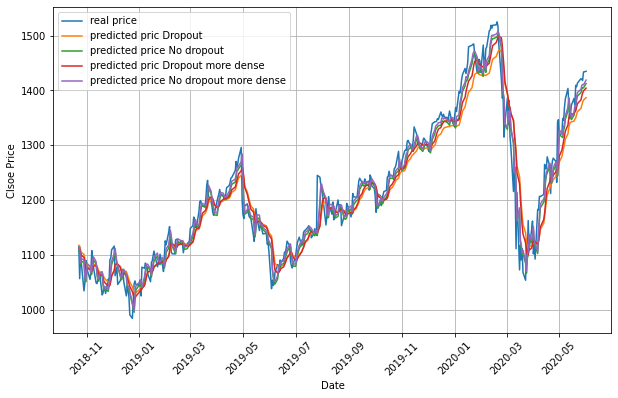

In [39]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_dropout,  label = 'predicted pric Dropout')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_nodropout,  label = 'predicted price No dropout')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_dropout_moredense,  label = 'predicted pric Dropout more dense')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU_nodropout_moredense,  label = 'predicted price No dropout more dense')

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.legend()
plt.grid()
plt.show()

# PART VIII

In [46]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
history_convlstm = History()
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = training_set
# choose a number of time steps
n_steps = 16
# split into samples
X, y = split_sequence(raw_seq, n_steps)
print(X.shape)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 8
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=20, verbose=1, callbacks=[history_convlstm])
# demonstrate prediction
x_input = x_test
x_input = x_input.reshape((x_input.shape[0], n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

(1593, 16, 1)
Epoch 1/20
50/50 [==============================] - 1s 6ms/step - loss: 158471.7223
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 938.8842
Epoch 3/20
50/50 [==============================] - 0s 7ms/step - loss: 598.8788
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 595.8555
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 609.4527
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 608.2117
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 616.5571
Epoch 8/20
50/50 [==============================] - 0s 6ms/step - loss: 581.0153
Epoch 9/20
50/50 [==============================] - 0s 6ms/step - loss: 547.4302
Epoch 10/20
50/50 [==============================] - 0s 6ms/step - loss: 535.4668
Epoch 11/20
50/50 [==============================] - 0s 6ms/step - loss: 616.3007
Epoch 12/20
50/50 [==============================] - 0s 6ms/step - loss: 630.8317
Epoch 13

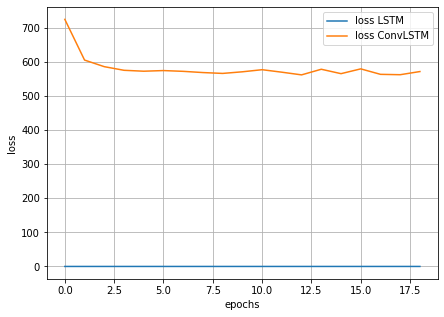

In [54]:
ls = pd.DataFrame({'loss LSTM':history_LSTM.history['loss'][1:],
                   'loss ConvLSTM':history_convlstm.history['loss'][1:]})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss')
plt.grid()

In [48]:
predicted_stock_price = model.predict(x_input)
predicted_stock_price_convlstm = scaler.inverse_transform(predicted_stock_price)

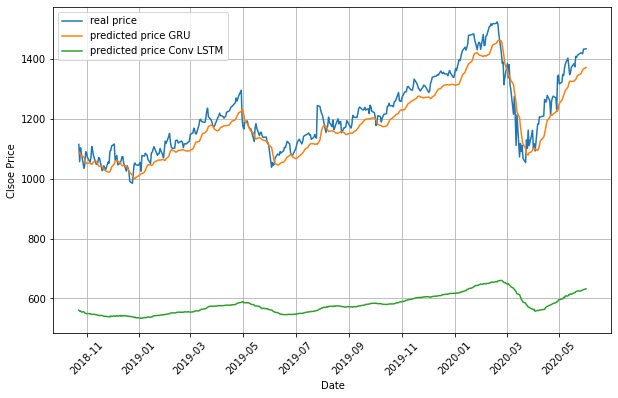

In [52]:
plt.figure(figsize = (10,6))
plt.plot(date_.loc[SPLIT:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU,  label = 'predicted price GRU')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_convlstm,  label = 'predicted price Conv LSTM')

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.legend()
plt.grid()
plt.show()

# PART XI

## Remove Data

In [271]:
np.random.seed(10)
remove_n = int(.25 * df.shape[0])
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [273]:
df_subset.shape, df.shape

((1509, 6), (2012, 6))

# PART XII

## Preprocessing

In [306]:
# split training set and test set

PRICE_TO_PREDICT = 'Close'
FEATURES = [PRICE_TO_PREDICT]
SPLIT2 = int(df_subset.shape[0] * .8)

training_set = df_subset[FEATURES][:SPLIT2].values
test_set = df_subset[FEATURES][SPLIT2:].values
print(f"training set shape: {training_set.shape} \ntest set shape: {test_set.shape}")

training set shape: (1207, 1) 
test set shape: (302, 1)


In [307]:
# scaling features

scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [308]:
# preprocess data to feed our model

TIME_STEP = 16
x_train = []
y_train = []

for i in range(TIME_STEP, SPLIT2):
    x_train.append(training_set_scaled[i-TIME_STEP:i, :])
    y_train.append(training_set_scaled[i,:])

x_train, y_train = np.array(x_train), np.array(y_train)
print(f"x train shape: {x_train.shape} \ny train shape: {y_train.shape}")

x train shape: (1191, 16, 1) 
y train shape: (1191, 1)


In [309]:
# preprocess test data
date_2 = pd.DataFrame(df_subset.index)
dataset_train = df_subset.iloc[:SPLIT2, 3:4]
dataset_test = df_subset.iloc[SPLIT2:, 3:4]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = df_subset[FEATURES][SPLIT2 - TIME_STEP:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(TIME_STEP, len(inputs)):
    x_test.append(inputs[i-TIME_STEP:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"x test shape: {x_test.shape}")

x test shape: (302, 16, 1)


## LSTM Model

In [284]:
history_unbalanced = History()

model = Sequential()

model.add(GRU(units = 50,
               return_sequences = True, 
               input_shape = x_train.shape[1:]))
model.add(Dropout(0.2))

model.add(GRU(units = 50,
               return_sequences = True))
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

model.fit(x_train, y_train, 
          epochs = 20, verbose = 0, validation_split = 0.1, batch_size = 32,
          callbacks=[history_unbalanced])


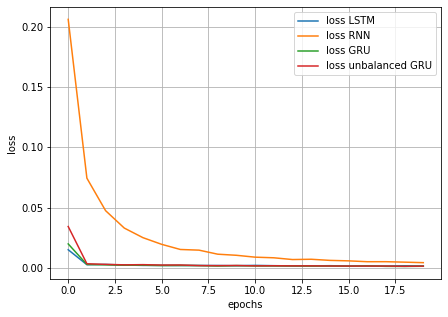

In [285]:
ls = pd.DataFrame({'loss LSTM':history_LSTM.history['loss'],
                   'loss RNN':history_RNN.history['loss'],
                   'loss GRU':history_GRU.history['loss'],
                   'loss unbalanced GRU':history_unbalanced.history['loss']})
ls.plot(figsize=(7,5))
plt.xlabel('epochs'), plt.ylabel('loss')
plt.grid()

In [310]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price_unbalanced = scaler.inverse_transform(predicted_stock_price)

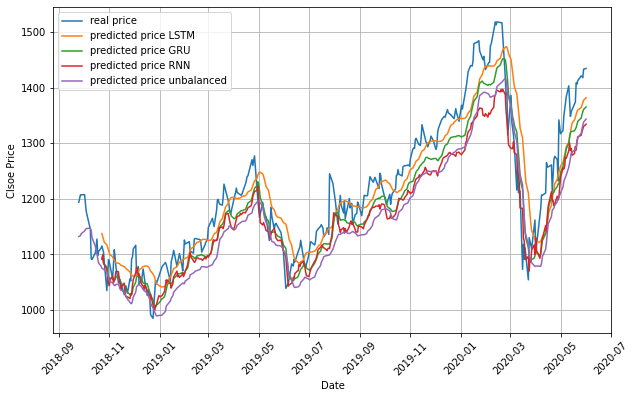

In [313]:
plt.figure(figsize = (10,6))
plt.plot(date_2.loc[SPLIT2:, 'Date'], dataset_test.values, label = 'real price')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_LSTM,  label = 'predicted price LSTM')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_GRU,  label = 'predicted price GRU')
plt.plot(date_.loc[SPLIT:, 'Date'], predicted_stock_price_RNN,  label = 'predicted price RNN')
plt.plot(date_2.loc[SPLIT2:, 'Date'], predicted_stock_price_unbalanced,  label = 'predicted price unbalanced')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Clsoe Price')
plt.legend()
plt.grid()
plt.show()